In [1]:
# use env glamm
import sys
sys.path.append('/home/ksmehrab/GLAMM/groundingLMM')

In [2]:
import cv2
import random
import argparse
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, CLIPImageProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image

from model.GLaMM import GLaMMForCausalLM
from model.llava import conversation as conversation_lib
from model.llava.mm_utils import tokenizer_image_token
from model.SAM.utils.transforms import ResizeLongestSide
from tools.generate_utils import center_crop, create_feathered_mask
from tools.utils import DEFAULT_IM_END_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from tools.markdown_utils import (markdown_default, examples, title, description, article, process_markdown, colors,
                                  draw_bbox, ImageSketcher)

/home/ksmehrab/miniconda/envs/glamm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from tqdm import tqdm

In [4]:
from app_modified import(
    inference
)

---- Initialized tokenizer from: MBZUAI/GLaMM-RefSeg ----


Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


---- Initialized model from: MBZUAI/GLaMM-RefSeg ----
---- Initialized Global Image Encoder (vision tower) from: openai/clip-vit-large-patch14-336 ----


Some weights of the model checkpoint at openai/clip-vit-large-patch14-336 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.6.mlp.fc2.weight', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.5.self_attn.v_proj.weight', 'text_model.encoder.layers.1.self_attn.k_proj.bias', 'text_model.encoder.layers.5.self_attn.out_proj.bias', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.1.layer_norm1.bias', 'text_model.encoder.layers.2.self_attn.out_proj.bias', 'text_model.encoder.layers.10.mlp.fc2.weight', 'text_model.encoder.layers.5.mlp.fc2.bias', 'text_model.embeddings.position_ids', 'text_model.encoder.layers.3.self_attn.k_proj.bias', 'text_model.encoder.layers.10.mlp.fc1.weight', 'text_model.encoder.lay

In [8]:
def get_image_token_indices_for_single_image(
    output_ids, 
    im_start_token_id=32000,
    number_of_image_tokens=576
):
    """Get the indices of image tokens in the input_ids/output_ids for a single image.

    Args:
        output_ids (torch.Tensor): The output IDs tensor of shape (seq_len,). The output IDs will contain the
        input IDs followed by the generated IDs.
        im_start_token_id (int): The token ID representing the start of an image token sequence. For our model, this is 32000.
        number_of_image_tokens (int): The number of image tokens per image. For our model, this is 576.
    """
    # Find the index of the first occurrence of the im_start_token_id
    token_index = (output_ids == im_start_token_id).nonzero(as_tuple=True)[0].item()
    
    image_token_start_index = token_index + 1  # The image tokens start right after the im_start_token_id
    image_token_end_index = image_token_start_index + number_of_image_tokens  # End index
    
    return (image_token_start_index, image_token_end_index)

In [9]:
def get_reverse_index_of_seg_token(output_ids, seg_token_id=32004):
    """Get the reverse index of the seg token in the output_ids. Reverse index is 1-indexed, so we can use it in python negative indexing.

    Args:
        output_ids (torch.Tensor): The output IDs tensor of shape (seq_len,). The output IDs will contain the
        input IDs followed by the generated IDs.
        seg_token_id (int): The token ID representing the seg token. For our model, this is 32004.
    """
    # Find the index of the first occurrence of the seg_token_id
    token_index = (output_ids == seg_token_id).nonzero(as_tuple=True)[0].item()
    
    reverse_index = len(output_ids) - token_index - 1  # Reverse index calculation. We do -1 because we want the scores of the token after the seg token. Example: if generated_output_ids = [18585, 29892, 32004, 869, 2], we want the scores of token 869 (since SEG token has already been generated at this step, and SEG is used used as query to get attention scores for token 869). The required index is 5 (length) - 2 (index of SEG or 32004) - 1 = 2 
    
    return reverse_index

In [10]:
def extract_visual_attention(attentions, num_layer, num_head, reverse_index_of_seg_token, image_token_start_index, image_token_end_index):
    required_attentions = attentions[-reverse_index_of_seg_token]
    attention_matrix = required_attentions[num_layer][:, num_head, :, :].squeeze().detach().cpu()
    # print(attention_matrix.shape)
   
    req_attention_map = attention_matrix[-1][image_token_start_index:image_token_end_index]
    # print(sequence_attention[idx][image_token_start_idx:image_token_end_idx].shape)
    return req_attention_map

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def get_np_image_from_tensor(
    images_tensor, 
    batch_dimension=True,
    show=True
):
    if batch_dimension:
        # Remove the batch dimension
        images_tensor = images_tensor.squeeze(0)

    # CLIP ImageNet normalization stats
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    
    # Denormalize: x = (x_normalized * std) + mean
    images_tensor = (images_tensor * std) + mean
    
    # Clamp to [0, 1] range
    images_tensor = torch.clamp(images_tensor, 0, 1)
    
    # Convert to numpy and scale to [0, 255]
    image_np = images_tensor.detach().cpu().float().permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    if show:
        # Plot the image
        plt.imshow(image_np)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()
    
    return image_np

In [12]:
import matplotlib.cm as cm
def plot_attention_map(attention_map, image_np):
    # Reshape the attention scores to 24x24
    attention_map = attention_map.reshape(24, 24).numpy().astype(np.float32)

    """
    We can look into better ways of scaling the attention map, but for now, we'll use the min-max normalization.
    """
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    # Resize the attention map to 336x336 to match the image size using nearest interpolation
    attention_map = torch.tensor(np.kron(attention_map, np.ones((14, 14))))  # Upsample to (336, 336)

    # Convert the attention map to a heatmap (jet colormap)
    heatmap = cm.jet(attention_map.numpy())  # Returns an RGBA image
    heatmap = np.uint8(heatmap * 255)  # Convert to 0-255 range
    heatmap_image = Image.fromarray(heatmap).convert('RGB')  # Convert to RGB format

    image_rgb = Image.fromarray(image_np.astype('uint8'), 'RGB')

    # Blend the heatmap with the original image (using some transparency)
    blended_image = Image.blend(image_rgb, heatmap_image, alpha=0.5)

    return blended_image

In [17]:
input_image = "/data/PartSegmentationDatasets/PascalPart/examples/2008_006462.jpg"
# input_image = "/home/ksmehrab/AttentionGrounding/sample_images/Yellow_Headed_Blackbird_0007_8366.jpg"
prompt_text = "Please segment the cat's eye in the picture."
all_inputs = {"boxes": [], "image": input_image}
follow_up = False
generate = False
output_image, markdown_out, seg_mask, attentions, input_ids, output_ids, tokenizer, global_enc_image = inference(
     prompt_text, all_inputs, follow_up, generate, return_attentions=True, verbose=True
)
tokenizer.encode("[SEG]")

input_str:  Please segment the cat's eye in the picture. input_image:  /data/PartSegmentationDatasets/PascalPart/examples/2008_006462.jpg
text_output:  Sure, it is [SEG] .</s>


[1, 32004]

In [19]:
image_token_start_index, image_token_end_index = get_image_token_indices_for_single_image(output_ids)

reverse_index_of_seg_token = get_reverse_index_of_seg_token(output_ids)
# get the required attention scores. This will be attentions[-reverse_index_of_seg_token]

required_attentions = attentions[-reverse_index_of_seg_token]

all_attentions = {}
for num_layer in tqdm(range(32)):
    all_attentions[num_layer] = {}
    for num_head in range(32):

        attention_map = extract_visual_attention(attentions, num_layer, num_head, reverse_index_of_seg_token, image_token_start_index, image_token_end_index)

        all_attentions[num_layer][num_head] = attention_map


100%|██████████| 32/32 [00:00<00:00, 218.85it/s]


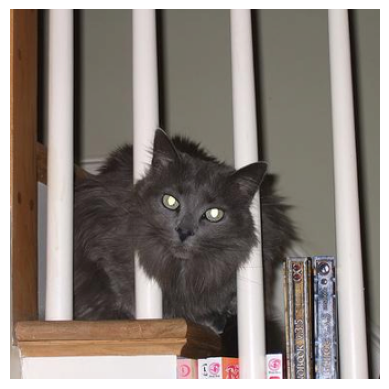

In [20]:
image_np = get_np_image_from_tensor(global_enc_image.float().cpu())

In [21]:
attention_layer = 21
attention_maps = all_attentions[attention_layer]

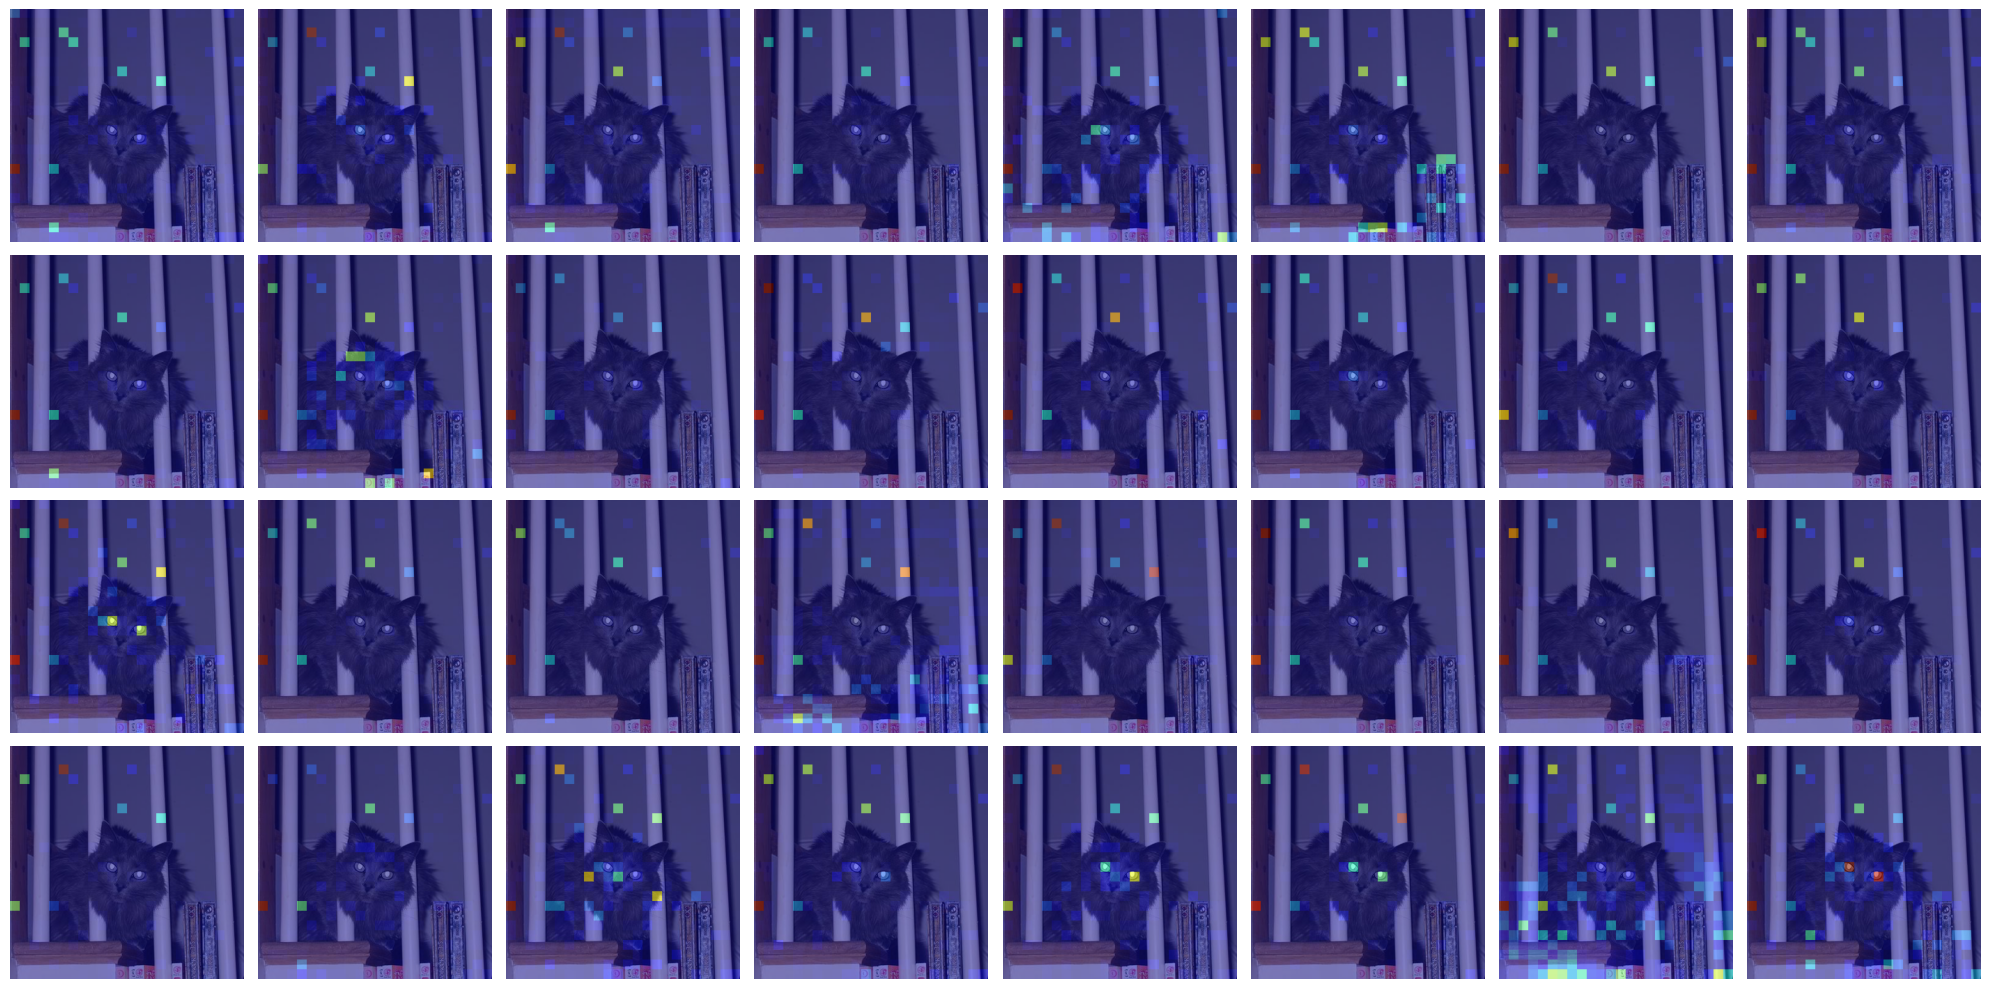

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    # print(i)
    blended_image = plot_attention_map(attention_maps[i].float(), image_np=image_np)
    ax.imshow(blended_image)
    ax.axis('off')  

plt.tight_layout()
plt.show()